In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn
from scipy import stats
import statsmodels.stats.multitest as smm

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Turning off warnings for neatness
import warnings
warnings.filterwarnings('ignore')


## Introduction

In this notebook, we demonstrate the use of significance testing using 3 approaches, as well as show and briefly discuss some differences between them.

This is done on an example of Standford School of Medicine dataset, describing gene activities among cancer patients.

Methods used:
- Basic T-Tests
- FWER corrected T-Tests
- FDR corrected T-Tests

Notebook demonstrates a few important points:
 - Using Standard T-tests without applying multi test correction may yield too many statistically different results, with a high proportion of Type I erros
 - Using FWER correction, while making sure that amount of Type I errors is minimized, may have a negative impact on the amount of interesting finidings obtained from the study due to a high proportion of Type II errors
 - Using FDR correction overcomes some problems of FWER correction, but allows for more Type I errors
 

In [3]:
Raw=pd.read_csv("gene_high_throughput_sequencing.csv")

## Data Description & Basic Expolration

Data comes from a study run by Stanford School of Medicine. The goal of the trial was to explore if there's a set of genes which activation is different between patiens on different stages of cancer and non-affected people.

The sample consisted of:
- 24 people w/o breast cancer (normal group)
- 25 people with early diagnosis (early neoplasia)
- 23 people with strong symptoms (cancer)

Dataset consists of observation of "gene activity" of 15748 genes for each person in the sample.

Our goal is to identify the genes which are significantly more or less "active" depending on various stage of desease.

Additionally, we will try identifiying if apart from being statistically significant, the differences are practically useful.

In [4]:
print("Rows in file = %.0f, Columns in file=%.0f" % Raw.shape)
Raw.head()

Rows in file = 72, Columns in file=15750


,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


We see that the datafile essentially consists of ID **Patient_id**, Diagnosis **Diagnosis** and 15748 columns with gene activity information.


Let's have a look at distributions and correlations of a few (first 5) genes, and include diagnosis as colour to see if there's come correlation of diagnosis with it.

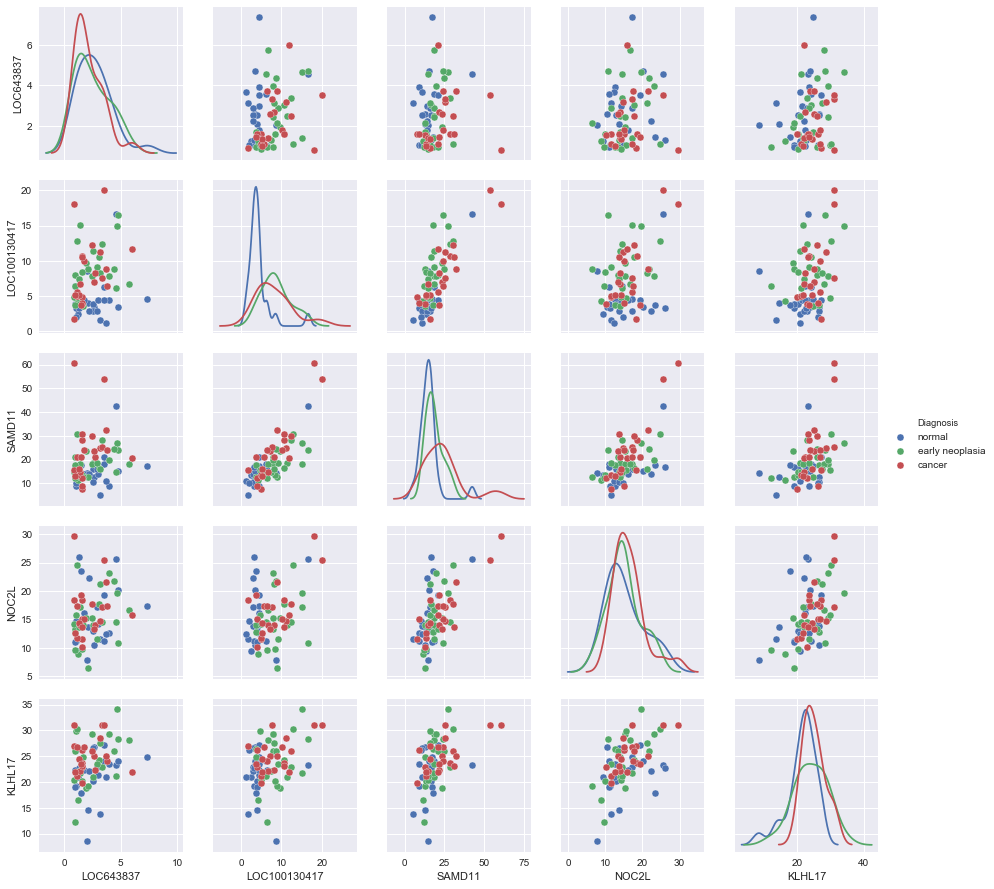

In [5]:
seaborn.pairplot(Raw.iloc[:,1:7], 
                 hue="Diagnosis", 
                 diag_kind="kde")

There are a few points to be made just from these charts on 5 genes:
- Activities of some genes may be correlated
- Genes LOC100130417 and SAMD11 for example, seem to be distributed a bit differently for patients without cancer - so out study seems to have merit.

## Basic T-tests

To start with, we will run basic t-tests for mean equality, between the following groups:

- normal vs. early neoplasia
- early neoplasia vs. cancer
- normal vs. cancer

Our samples are independent (results are collected from different people), so we will use scipy.stats.ttest_ind.

Now, we know that testing like this is inappropriate and we need to use multitest corrections, but we need to get the p-values anyway before applying the correction.

In [6]:
def t_compare_means(group1,group2):
    
    # Run T-Tests
    TTests=Raw.iloc[:,3:].apply(
        lambda x: stats.ttest_ind(x[Raw.Diagnosis==group1],x[Raw.Diagnosis==group2],equal_var=False),
        axis=0)
    
    # Split t-test tuples and store them in data.frame
    res=pd.DataFrame(
        list(zip(*zip(*TTests))),
        index=TTests.index)
    
    # Clean-up data-frame
    res.columns=["TStatistic","PValue"]
    
    return(res)

In [7]:
NormalVsEarly=t_compare_means("normal","early neoplasia")
EarlyVsCancer=t_compare_means("early neoplasia","cancer")
NormalVsCancer=t_compare_means("normal","cancer")

Let's have a look at distributions of Genes with top-5 T-Statistics for normal vs. cancer

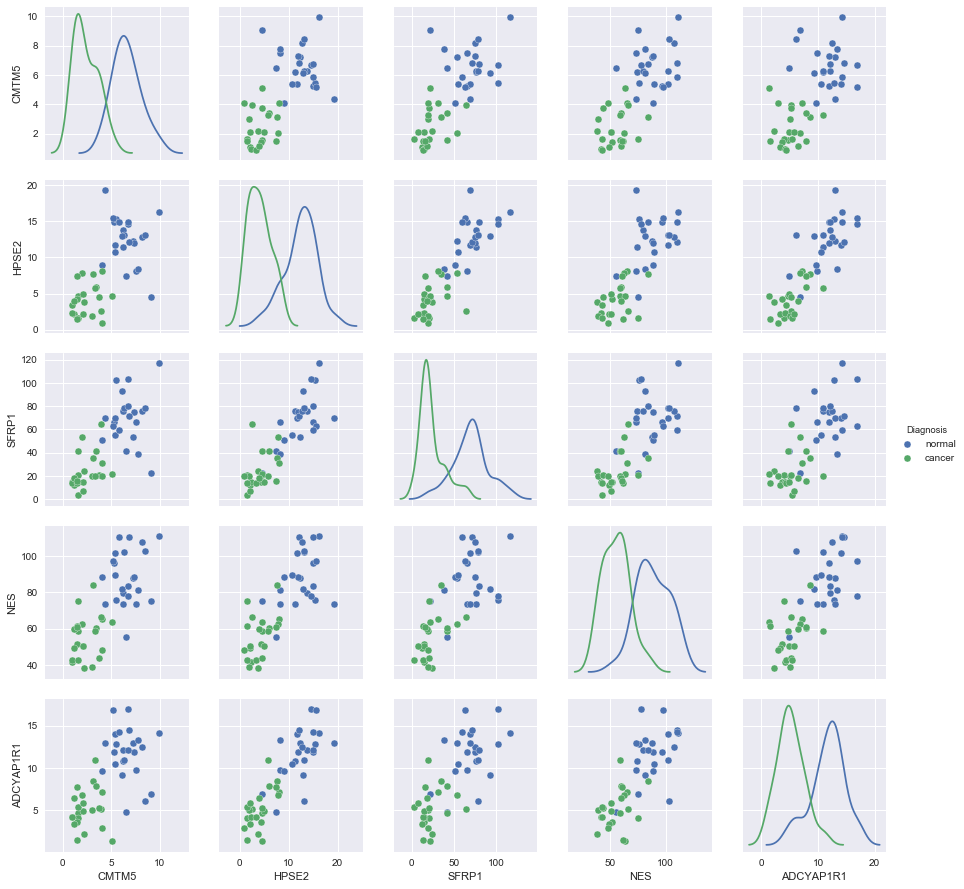

In [8]:
# Take top-5 indexes of P-Value sorted data.frame and Diagnosis
# Easier to sort by P Value, than to take abs of T
NamesForChart=list(NormalVsCancer.sort_values(by="PValue").index[:5])
NamesForChart.append("Diagnosis")

seaborn.pairplot(Raw.loc[Raw.Diagnosis!="early neoplasia",NamesForChart], 
                 hue="Diagnosis", 
                 diag_kind="kde")

We can see clear differences in gene activities between "normal" and "cancer" groups. 

Let's have a look at how many null-hypotheses we decline for each of the comparisons

In [9]:
print("%.0f Hypotheses rejected for Normal Vs Early" % 
      np.sum(NormalVsEarly.PValue<0.05))
print("%.0f Hypotheses rejected for Early Vs Cancer" % 
      np.sum(EarlyVsCancer.PValue<0.05))
print("%.0f Hypotheses rejected for Normal Vs Cancer" % 
      np.sum(NormalVsCancer.PValue<0.05))

1575 Hypotheses rejected for Normal Vs Early
3490 Hypotheses rejected for Early Vs Cancer
4059 Hypotheses rejected for Normal Vs Cancer


## FWER Holm - Bonferroni correction

Since we are running a lot of different tests, we can not just reject those based on a non-modified P-Value. This may result in way too many Type I errors. FWER correction will ensure probability of getting 1 or more Type I errors is below our alpha of 0.05.

Hence, we will peform Holm - Bonferroni step-down correction (since using just Bonferroni is lame and will inflate Type II error more than H-B)

Since we are running 3 sets of tests, we are also going to apply pure Bonferroni to alpha before running H-B correction on each of them


In [10]:
rej,pval_corr,_,_=smm.multipletests(NormalVsEarly.PValue,alpha=0.05/3,method="h")
NormalVsEarly=NormalVsEarly.assign(RejectionCorr=rej,PValCorr=pval_corr)

rej,pval_corr,_,_=smm.multipletests(EarlyVsCancer.PValue,alpha=0.05/3,method="h")
EarlyVsCancer=EarlyVsCancer.assign(RejectionCorr=rej,PValCorr=pval_corr)

rej,pval_corr,_,_=smm.multipletests(NormalVsCancer.PValue,alpha=0.05/3,method="h")
NormalVsCancer=NormalVsCancer.assign(RejectionCorr=rej,PValCorr=pval_corr)

In [11]:
print("%.0f Hypotheses rejected for Normal Vs Early after H-B correction" % 
      np.sum(NormalVsEarly.RejectionCorr))
print("%.0f Hypotheses rejected for Early Vs Cancer after H-B correction" % 
      np.sum(EarlyVsCancer.RejectionCorr))
print("%.0f Hypotheses rejected for Normal Vs Cancer after H-B correction" % 
      np.sum(NormalVsCancer.RejectionCorr))

2 Hypotheses rejected for Normal Vs Early after H-B correction
75 Hypotheses rejected for Early Vs Cancer after H-B correction
136 Hypotheses rejected for Normal Vs Cancer after H-B correction


As it can be seen, much less null hypothesis are rejected now. On a good side, there's only a 0.05 chance any one of them was rejected wrongly.

## Combining statistical and practical significance

However, the fact that the differences are statistically significant do not guarantee they will be useable on practice. Hence, we introduce fold change metric commonly used in such studies.

\begin{equation*}
F_c(C, T) = 
\begin{cases} 
\frac{T}{C}, & T > C \\
\frac{C}{T}, & T < C 
\end{cases}
\end{equation*}

Where T & C are mean gene activities in different groups

Let's see how many of our differences are both statistically different and have fold_change over 1.5



In [12]:
def fold_change(T,C):
    if T>C:
        return(T/C)
    else:
        return(C/T)

def fold_changes_between_groups(group1,group2):
    
    # Run F_Changes
    F_Changes=Raw.iloc[:,3:].apply(
        lambda x: 
            fold_change(
                x[Raw.Diagnosis==group1].mean(),
                x[Raw.Diagnosis==group2].mean()
            ),
        axis=0)
    
    # Store it in nice DF
    res=pd.DataFrame(F_Changes,index=F_Changes.index)
    
    # Clean-up data-frame
    res.columns=["F_C"]
    
    return(res)

In [13]:
NormalVsEarly_FC=fold_changes_between_groups("normal","early neoplasia")
EarlyVsCancer_FC=fold_changes_between_groups("early neoplasia","cancer")
NormalVsCancer_FC=fold_changes_between_groups("normal","cancer")

In [14]:
print("%.0f statistically and practically different gene(s) between" \
      " Normal and Early groups"% 
      np.sum((NormalVsEarly_FC.F_C>1.5)&NormalVsEarly.RejectionCorr))

print("%.0f statistically and practically different gene(s) between" \
      " Early and Cancer groups"% 
      np.sum((EarlyVsCancer_FC.F_C>1.5)&EarlyVsCancer.RejectionCorr))

print("%.0f statistically and practically different gene(s) between" \
      " Normal and Cancer groups"% 
      np.sum((NormalVsCancer_FC.F_C>1.5)&NormalVsCancer.RejectionCorr))

2 statistically and practically different gene(s) between Normal and Early groups
73 statistically and practically different gene(s) between Early and Cancer groups
125 statistically and practically different gene(s) between Normal and Cancer groups


## FDR correction

Holm-Bonferroni correction is great, but it makes sure that probability to make >0 Type I errors is below alpha. On one hand, it is great because we are relatively sure we will not make even a single Type I error. On the other hand, this approach may be too harsh and make us not decline a lot of false null hypotheses, making our analysis produce less interesting results.

To overcome this, an FDR correction can be used. This means we expect ~alpha of our rejected hypothesis to actually be true, so we control expected proportion of Type I errors among total rejected hypothesis. As a result, we will decline much more really false null hypotheses, while only rejecting a few true ones. One can say we will sacrifice getting a few more Type I errors for getting much less Type II errors.

Corrections such as Benjamini-Hochberg and Benjamini-Yekutieli provide such functionality. However, Benjamini-Hochberg requires for the tests to be uncorrelated, and we have just seen on the charts above that some gene activities are strongly correlated.

Hence, we will use Benjamini-Yekutieli (but still use Bonferroni to correct alpha input into smm.multitests to make the code simpler).


In [15]:
rej,pval_corr,_,_=smm.multipletests(NormalVsEarly.PValue,alpha=0.05/3,method="fdr_by")
NormalVsEarly=NormalVsEarly.assign(RejectionCorr=rej,PValCorr=pval_corr)

rej,pval_corr,_,_=smm.multipletests(EarlyVsCancer.PValue,alpha=0.05/3,method="fdr_by")
EarlyVsCancer=EarlyVsCancer.assign(RejectionCorr=rej,PValCorr=pval_corr)

rej,pval_corr,_,_=smm.multipletests(NormalVsCancer.PValue,alpha=0.05/3,method="fdr_by")
NormalVsCancer=NormalVsCancer.assign(RejectionCorr=rej,PValCorr=pval_corr)

print("%.0f Hypotheses rejected for Normal Vs Early after fdr_by correction" % 
      np.sum(NormalVsEarly.RejectionCorr))
print("%.0f Hypotheses rejected for Early Vs Cancer after fdr_by correction" % 
      np.sum(EarlyVsCancer.RejectionCorr))
print("%.0f Hypotheses rejected for Normal Vs Cancer after fdr_by correction" % 
      np.sum(NormalVsCancer.RejectionCorr))

1 Hypotheses rejected for Normal Vs Early after fdr_by correction
178 Hypotheses rejected for Early Vs Cancer after fdr_by correction
403 Hypotheses rejected for Normal Vs Cancer after fdr_by correction


Clearly, using this correction results in more statistically different gene activities found, and only around 0.05 of those we expect to be Type I errors.

Thus, FDR correction allows us to find much more interesting results. The price paid for that is a proportion of rejected hypothesis which are actually true (however, only around ~alpha of them).

In [16]:
print("%.0f statistically and practically different gene(s) between" \
      " Normal and Early groups"% 
      np.sum((NormalVsEarly_FC.F_C>1.5)&NormalVsEarly.RejectionCorr))

print("%.0f statistically and practically different gene(s) between" \
      " Early and Cancer groups"% 
      np.sum((EarlyVsCancer_FC.F_C>1.5)&EarlyVsCancer.RejectionCorr))

print("%.0f statistically and practically different gene(s) between" \
      " Normal and Cancer groups"% 
      np.sum((NormalVsCancer_FC.F_C>1.5)&NormalVsCancer.RejectionCorr))

1 statistically and practically different gene(s) between Normal and Early groups
159 statistically and practically different gene(s) between Early and Cancer groups
333 statistically and practically different gene(s) between Normal and Cancer groups


Importantly, not all statistically significant results are practically significant. It is important to remember this at a later stage of analysis to make sure we focus it on things which are practically important.

## Brief Discussion & Saving results

### Method demonstration 

In this notebook, we demonstrate using 3 approaches to sig. testing differences in gene activities between groups of cancer patients:
 - Standart T-test
 - FWER correction
 - FDR correction
 
Notebook demonstrates a few important points:
 - Using Standard T-tests without applying multi test correction may yield too many statistically different results, with a high proportion of Type I erros
 - Using FWER correction, while making sure that amount of Type I errors is minimized, may have a negative impact on the amount of interesting finidings obtained from the study due to a high proportion of Type II errors
 - Using FDR correction overcomes some problems of FWER correction, but allows for more Type I errors
 
### Practical viewpoint

From a practical view point, we have shown that there is indeed a proportion of genes which have different activities depending on cancer stage and presence. This result can be further used to develop algorithms for detection and classification of cancer on real - life patients.


Finally, we did not do all this work for nothing!
Let's save the results of our small experiment for later use. 

In [17]:
NormalVsEarly=NormalVsEarly.assign(F_C=NormalVsEarly_FC.F_C)
NormalVsEarly.to_csv("NormalVsEarlyGeneDifferences.csv")

EarlyVsCancer=EarlyVsCancer.assign(F_C=EarlyVsCancer_FC.F_C)
EarlyVsCancer.to_csv("EarlyVsCancerGeneDifferences.csv")

NormalVsCancer=NormalVsCancer.assign(F_C=NormalVsCancer_FC.F_C)
NormalVsCancer.to_csv("NormalVsCancerGeneDifferences.csv")
